In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [64]:
RANDOM_STATE = 42
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
tf.random.set_seed(RANDOM_STATE)

In [65]:
# --- Data Loading ---
try:
    df = pd.read_csv('laptop_prices.csv')
except FileNotFoundError:
    print("Error: 'laptop_prices.csv' not found.")
    exit()

In [66]:
# Price_euros is the target variable
df['Price_euros'] = pd.to_numeric(df['Price_euros'], errors='coerce')

In [67]:
# Drop 'Product' and other redundant/complex features
df = df.drop(columns=['Product', 'SecondaryStorageType', 'GPU_company'])

# Feature Engineering 

In [68]:
# 1. Simplify OS (e.g., to Windows, Mac, Linux/Other)
def simplify_os(os_name):
    if 'Windows' in os_name: return 'Windows'
    elif 'macOS' in os_name or 'Mac OS' in os_name: return 'Mac'
    elif 'Linux' in os_name: return 'Linux'
    else: return 'Other/No OS'
df['OS_simplified'] = df['OS'].apply(simplify_os)
df.drop(columns=['OS'], inplace=True)

In [69]:
# 2. Extract Base CPU Type (e.g., 'i7' from 'Core i7')
def extract_cpu_type(model):
    if 'i7' in model: return 'i7'
    elif 'i5' in model: return 'i5'
    elif 'i3' in model: return 'i3'
    elif 'Celeron' in model or 'Pentium' in model or 'AMD' in model: return 'Low-End'
    else: return 'Other'
df['CPU_Type'] = df['CPU_model'].apply(extract_cpu_type)
df.drop(columns=['CPU_model'], inplace=True)

In [70]:
# 3. Combine Storage into a single total storage metric (Primary + Secondary)
df['Total_Storage_GB'] = df['PrimaryStorage'] + df['SecondaryStorage']
df.drop(columns=['PrimaryStorage', 'SecondaryStorage'], inplace=True)

In [71]:
# 4. Feature for High Resolution Screens (combine ScreenW, ScreenH)
# High_Res is a 0/1 (int) column and will be passed through as numeric
df['High_Res'] = ((df['ScreenW'] >= 1920) | (df['ScreenH'] >= 1080)).astype(int)
df.drop(columns=['ScreenW', 'ScreenH'], inplace=True)

In [72]:
# 5. Target Transformation: Use Log Transformation for Price
df['Log_Price_euros'] = np.log1p(df['Price_euros'])
df.dropna(subset=['Log_Price_euros'], inplace=True)

# Exploratory Data Analysis

Text(0.5, 1.0, '1. Log-Transformed Price Distribution')

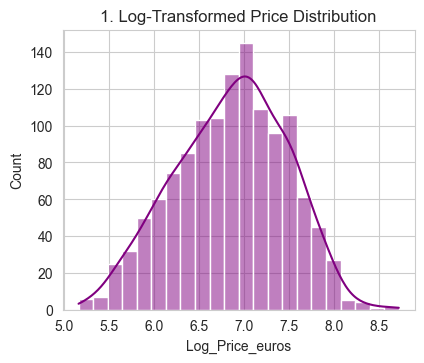

In [73]:
# Plot 1: Distribution of the Target Variable (Log Price)
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.histplot(df['Log_Price_euros'], kde=True, color='purple')
plt.title('1. Log-Transformed Price Distribution')

C:\Users\91960\AppData\Local\Temp\ipykernel_11900\2002183353.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ram', y='Log_Price_euros', data=df, palette='viridis')


Text(0.5, 0, 'RAM (GB)')

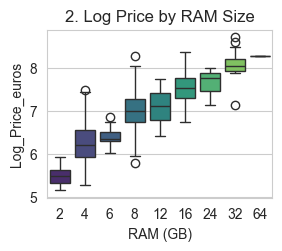

In [74]:
# Plot 2: Price vs. RAM (Box Plot)
plt.subplot(2, 2, 2)
sns.boxplot(x='Ram', y='Log_Price_euros', data=df, palette='viridis')
plt.title('2. Log Price by RAM Size')
plt.xlabel('RAM (GB)')

C:\Users\91960\AppData\Local\Temp\ipykernel_11900\1136080789.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CPU_Type', y='Log_Price_euros', data=df, palette='cividis')


Text(0.5, 0, 'CPU Type')

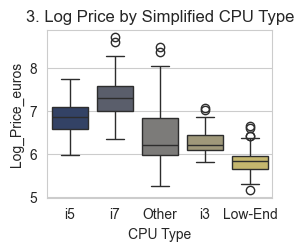

In [75]:
# # Plot 3: Price vs. CPU Type (Box Plot)
plt.subplot(2, 2, 3)
sns.boxplot(x='CPU_Type', y='Log_Price_euros', data=df, palette='cividis')
plt.title('3. Log Price by Simplified CPU Type')
plt.xlabel('CPU Type')

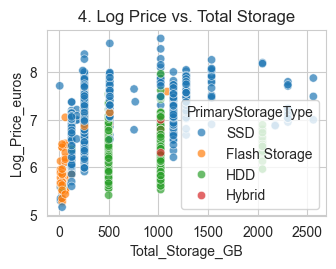

In [76]:
# Plot 4: Price vs. Total Storage (Scatter Plot)
plt.subplot(2, 2, 4)
sns.scatterplot(x='Total_Storage_GB', y='Log_Price_euros', data=df, hue='PrimaryStorageType', alpha=0.7)
plt.title('4. Log Price vs. Total Storage')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [77]:
# Define Features and Target
TARGET = 'Log_Price_euros'
# Drop the target and the original price column
FEATURES = df.drop(columns=[TARGET, 'Price_euros']).columns.tolist() 
# Drop 'GPU_model' as it's too high-cardinality/complex and was not simplified
FEATURES.remove('GPU_model')


In [78]:
X = df[FEATURES]
y = df[TARGET]

In [79]:
# Identify feature types
NUMERICAL_FEATURES = ['Inches', 'Ram', 'Weight', 'CPU_freq', 'Total_Storage_GB']

In [80]:
# CRITICAL FIX: All features that are strings MUST go to the categorical pipeline
CATEGORICAL_FEATURES = X.select_dtypes(include=['object']).columns.tolist()

In [81]:
# This feature is now numeric (0 or 1) due to Cell 2 engineering and can be passed through
NUMERIC_PASSTHROUGH = ['High_Res']

In [82]:
# --- Preprocessing Pipeline Configuration ---
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE))
])

In [83]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [84]:
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, NUMERICAL_FEATURES),
        # ALL string features (including Touchscreen, IPSpanel, RetinaDisplay, etc.) go here
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES), 
        # Only the engineered numeric column is passed through
        ('passthrough', 'passthrough', NUMERIC_PASSTHROUGH) 
    ],
    remainder='drop'
)

In [85]:
# Apply Preprocessor and Split Data
X_processed = preprocessor.fit_transform(X)

In [86]:
# Get feature names after OHE for feature importance and analysis
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
processed_feature_names = NUMERICAL_FEATURES + list(cat_feature_names) + NUMERIC_PASSTHROUGH

In [87]:
X_final = pd.DataFrame(X_processed, columns=processed_feature_names)

In [88]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=RANDOM_STATE
)

In [89]:
print(f"Final training set shape: {X_train.shape}")

Final training set shape: (1020, 57)


# Model Training

In [90]:
# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [91]:
# 2. Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
rf_reg.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [92]:
# 3. Gradient Boosting Regressor (Often the best for structured data)
gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=RANDOM_STATE)
gbr.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,150
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [93]:
# Deep Learning Model

In [94]:
# 4. Neural Network (MLP) Model
input_shape = X_train.shape[1]

In [95]:
def build_mlp_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear') # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [96]:
mlp_model = build_mlp_model(input_shape)

C:\Users\91960\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [97]:
# Train the model 
history = mlp_model.fit(X_train, y_train, 
                        epochs=50, 
                        batch_size=32, 
                        validation_split=0.1, 
                        verbose=0)

# Model Evaluation

In [98]:
# Helper function to inverse transform log-transformed prediction
def expm1_predict(y_pred_log):
    return np.maximum(np.expm1(y_pred_log), 0)

In [99]:
# Predictions (Log Scale)
y_pred_lin_log = lin_reg.predict(X_test)
y_pred_rf_log = rf_reg.predict(X_test)
y_pred_gbr_log = gbr.predict(X_test)
y_pred_mlp_log = mlp_model.predict(X_test, verbose=0).flatten()

In [100]:
# Inverse Transform Predictions and Actual Values (Original Euros Scale)
y_test_orig = np.expm1(y_test)
y_pred_lin_orig = expm1_predict(y_pred_lin_log)
y_pred_rf_orig = expm1_predict(y_pred_rf_log)
y_pred_gbr_orig = expm1_predict(y_pred_gbr_log)
y_pred_mlp_orig = expm1_predict(y_pred_mlp_log)

In [101]:
# Collect Evaluation Metrics (R2, MAE, RMSE)
def get_regression_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    return {
        'Model': model_name,
        'R-squared (R2)': r2_score(y_true, y_pred),
        'MAE (Euros)': mean_absolute_error(y_true, y_pred),
        'RMSE (Euros)': np.sqrt(mse)
    }

In [102]:
lin_metrics = get_regression_metrics(y_test_orig, y_pred_lin_orig, "Linear Regression")
rf_metrics = get_regression_metrics(y_test_orig, y_pred_rf_orig, "Random Forest")
gbr_metrics = get_regression_metrics(y_test_orig, y_pred_gbr_orig, "Gradient Boosting")
mlp_metrics = get_regression_metrics(y_test_orig, y_pred_mlp_orig, "Neural Network (MLP)")

In [103]:
regression_results = pd.DataFrame([lin_metrics, rf_metrics, gbr_metrics, mlp_metrics])

In [104]:
print("\n--- Model Evaluation: Laptop Price Prediction ---")
print(regression_results.set_index('Model').T.round(2).to_string())


--- Model Evaluation: Laptop Price Prediction ---
Model           Linear Regression  Random Forest  Gradient Boosting  Neural Network (MLP)
R-squared (R2)               0.75           0.82               0.84                  0.78
MAE (Euros)                243.83         189.18             187.23                239.64
RMSE (Euros)               353.32         296.46             283.90                331.87


In [105]:
# Identify Best Model
best_model_row = regression_results.loc[regression_results['R-squared (R2)'].idxmax()]
print(f"\nBest Model: {best_model_row['Model']} (R-squared: {best_model_row['R-squared (R2)']:.4f})")


Best Model: Gradient Boosting (R-squared: 0.8376)


# Feature Importance and Residuals

C:\Users\91960\AppData\Local\Temp\ipykernel_11900\1277648794.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='magma')


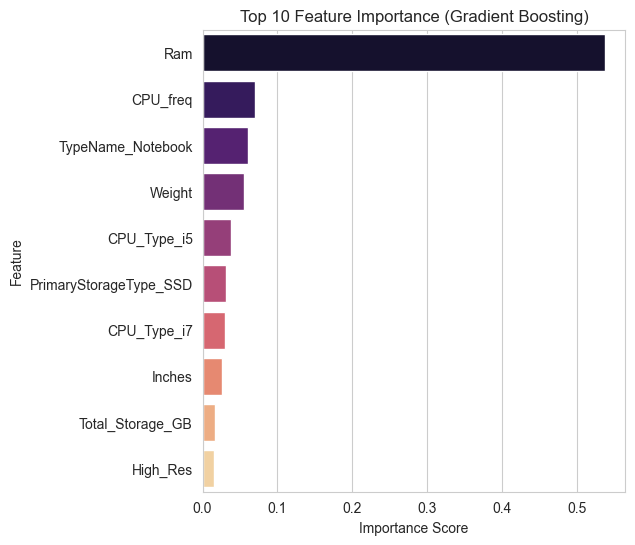

In [106]:
# 1. Feature Importance (Using the Best Ensemble Model: Gradient Boosting)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
importances = gbr.feature_importances_
feature_series = pd.Series(importances, index=X_train.columns)
top_10_features = feature_series.nlargest(10)
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='magma')
plt.title('Top 10 Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.show()



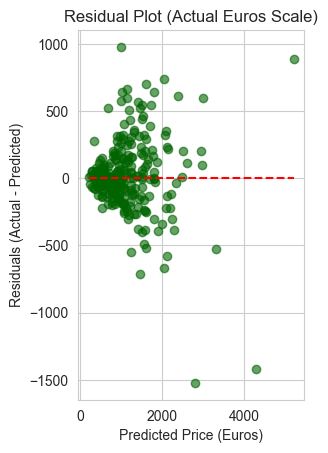

In [107]:
# 2. Residual Plot (Gradient Boosting)
plt.subplot(1, 2, 2)
residuals = y_test_orig - y_pred_gbr_orig
plt.scatter(y_pred_gbr_orig, residuals, alpha=0.6, color='darkgreen')
plt.hlines(0, xmin=min(y_pred_gbr_orig), xmax=max(y_pred_gbr_orig), color='red', linestyles='--')
plt.title('Residual Plot (Actual Euros Scale)')
plt.xlabel('Predicted Price (Euros)')
plt.ylabel('Residuals (Actual - Predicted)')

plt.show()

# Final Model Export

In [108]:
# Save the critical components
joblib.dump(gbr, 'gbr_laptop_price_regressor.pkl')
joblib.dump(preprocessor, 'full_preprocessor_laptop.pkl')
joblib.dump(rf_reg, 'rf_laptop_price_regressor.pkl')
# Saving Keras model
mlp_model.save('mlp_laptop_price_regressor.keras')

In [109]:
print("\n✅ Key models and preprocessors saved to disk for deployment.")


✅ Key models and preprocessors saved to disk for deployment.
